In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scipy
import time
import uuid

import matplotlib.pyplot as plt
import networkx as nx

from SPARQLWrapper import SPARQLWrapper, JSON, POST

from req_analysis import *

# Initialize connection to Neptune

In [3]:
%run 'req_analysis/libs/neptune-util.py'
%env NEPTUNE_CLUSTER_ENDPOINT=100.65.51.106
%env NEPTUNE_CLUSTER_PORT=8182
g = neptune.graphTraversal()

env: NEPTUNE_CLUSTER_ENDPOINT=100.65.51.106
env: NEPTUNE_CLUSTER_PORT=8182
gremlin: ws://100.65.51.106:8182/gremlin


# Initialize evaluation

In [4]:
sparql = SPARQLWrapper("https://cae-mms-rdf-test-r5-2x.cluster-cw2hjngge6pe.us-gov-west-1.neptune.amazonaws.com:8182/sparql")

In [5]:
ref_targets = ReferenceTarget(sparql)
ref_targets.init_table()

== Status Code: 200 ==
1951 reference targets found.


In [6]:
req_evaluator = RequirementEvaluator(sparql)
req_evaluator.init_requirement_elements()

== Status Code: 200 ==
3061 requirements found.


# Select a requirement
Change only `req_id` and verify the content of the requirement with the next cell

In [7]:
req_id = '_831_331c90b6-9e17-4c46-8530-0fc345e0a22f_asi'

In [8]:
req_evaluator.get_requirement_by_id(req_id)

{'slot': {'type': 'uri',
  'value': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_831_331c90b6-9e17-4c46-8530-0fc345e0a22f_asi-slot-_11_5EAPbeta_be00301_1147873226632_528960_2311'},
 'instance': {'type': 'uri',
  'value': 'https://opencae.jpl.nasa.gov/mms/rdf/element/_831_331c90b6-9e17-4c46-8530-0fc345e0a22f_asi'},
 'valueString': {'type': 'literal',
  'value': '<html><body>\n<span xmlns="http://www.w3.org/1999/xhtml"><strong>[REQ-1-OAD-0185]</strong> The Observatory Safety system decomposition element is defined as follows:<br/>Associated WBS element(s): TMT.TEL.CONT.OSS<br/>The Observatory Safety System (OSS) contributes to the enforcement of safe conditions throughout the summit facility by continuously monitoring the state of connected equipment, systems and sensors and taking appropriate action as soon as an unsafe condition is detected. It is independent from and supplementary to any safety systems and functionality that is contained within individual subsystems. Based on one or

<hr>

# Analysis

The analysis is made through an `Evaluation` object.\
A `RequirementEvaluator` object is just an abstraction layer on top of the `Evaluation`. Its purpose is to reference only the MMS ID of the requirement, and be able to do the whole analysis with a simple function.
For the purpose of this notebook (in depth demo), we will interact directly with the `Evaluation` instance.

In [9]:
req_evaluation = req_evaluator.get_evaluation_by_id(req_id, ref_targets)

## **Evaluation.match_tokens()**
This function compares each token (generated with [spacy](https://spacy.io/)) against all model elements in ReferenceTargets.\
Every match is returned, i.e. a token can be matched to multiple model elements and a single model element can be matched to multiple tokens.

In [10]:
matches, c = req_evaluation.match_tokens(0.0035)
for match in matches:
    print('Token: ', match['token']['text'])
    print('Element: ', match['model_element']['name'])
    print('URI: ', match['model_element']['uri'], '\n_________')

Token:  the Data Management System
Element:  Data Management System
URI:  https://opencae.jpl.nasa.gov/mms/rdf/element/_16566_c270fe21-19e7-4d0d-aa3c-31b76ad6ca8b 
_________
Token:  the Data Management System
Element:  Data Management System
URI:  https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_5_baa02e2_1450821286717_64577_153095 
_________
Token:  the Data Management System
Element:  Data Management System
URI:  https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_2_876026b_1427661004426_556776_143472 
_________
Token:  Executive Software
Element:  Executive Software
URI:  https://opencae.jpl.nasa.gov/mms/rdf/element/_17_0_2_3_41e01aa_1382542702961_630808_58999 
_________
Token:  network
Element:  Network
URI:  https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_6_876026b_1478280404909_609058_173008 
_________
Token:  networking
Element:  Networking
URI:  https://opencae.jpl.nasa.gov/mms/rdf/element/MMS_1456189351681_ad25f82c-607f-4103-83b1-75f605015749 
_________


## **Evaluation.init_match_subgraph()**
This function initializes a subgraph with all matched model elements, and their distance in the SysML model as edges (distance = number of hops for now).

In [11]:
G = req_evaluation.init_match_subgraph(g, pprint=True) 

0 1
Timeout: node_distance()
DISTANCE: in 3.0036258697509766 s  10
_________
0 2
Timeout: node_distance()
DISTANCE: in 3.0032482147216797 s  10
_________
0 3
Timeout: node_distance()
DISTANCE: in 3.0010759830474854 s  10
_________
0 4
Timeout: node_distance()
DISTANCE: in 3.0055148601531982 s  10
_________
0 5
Timeout: node_distance()
DISTANCE: in 3.002563714981079 s  10
_________
1 2
Timeout: node_distance()
DISTANCE: in 3.0058650970458984 s  10
_________
1 3
Timeout: node_distance()
DISTANCE: in 3.0014560222625732 s  10
_________
1 4
Timeout: node_distance()
DISTANCE: in 3.004296064376831 s  10
_________
1 5
Timeout: node_distance()
DISTANCE: in 3.0008621215820312 s  10
_________
2 3
Timeout: node_distance()
DISTANCE: in 3.004122018814087 s  10
_________
2 4
Timeout: node_distance()
DISTANCE: in 3.0040199756622314 s  10
_________
2 5
Timeout: node_distance()
DISTANCE: in 3.005218982696533 s  10
_________
3 4
Timeout: node_distance()
DISTANCE: in 3.0027618408203125 s  10
_________
3 5

### We can visualize the match subgraph

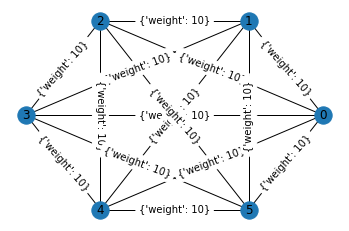

In [12]:
pos = nx.circular_layout(req_evaluation.matches_subgraph)
nx.draw_networkx_edge_labels(req_evaluation.matches_subgraph, pos)
nx.draw_circular(req_evaluation.matches_subgraph, with_labels=True)

## **Evaluation.match_clustering()**
Runs a hierarchical clustering on the match subgraph. The goal is to disambiguate if a token were matched to multiple model elements. The supposition is that the earlier a token gets into a cluster (so the closer it is to other model elements that were match), the more relevant it is.

In [13]:
definitive_matches = req_evaluation.match_clustering()
for match in definitive_matches.values():
    print('Token: ', match['token']['text'])
    print('Element: ', match['model_element']['name'])
    print('URI: ', match['model_element']['uri'], '\n_________')

Token:  the Data Management System
Element:  Data Management System
URI:  https://opencae.jpl.nasa.gov/mms/rdf/element/_16566_c270fe21-19e7-4d0d-aa3c-31b76ad6ca8b 
_________
Token:  Executive Software
Element:  Executive Software
URI:  https://opencae.jpl.nasa.gov/mms/rdf/element/_17_0_2_3_41e01aa_1382542702961_630808_58999 
_________
Token:  network
Element:  Network
URI:  https://opencae.jpl.nasa.gov/mms/rdf/element/_18_0_6_876026b_1478280404909_609058_173008 
_________
Token:  networking
Element:  Networking
URI:  https://opencae.jpl.nasa.gov/mms/rdf/element/MMS_1456189351681_ad25f82c-607f-4103-83b1-75f605015749 
_________


## **Evaluation.allocation_discovery()**
Work in progress. Should be able to cluster some matches together if they're close enough, and allocate to the "main" match instead.

In [14]:
allocations = req_evaluation.allocation_discovery(g)
for alloc in allocations:
    print(alloc['name'], '--->', alloc['mms_id'])

Data Management System ---> _16566_c270fe21-19e7-4d0d-aa3c-31b76ad6ca8b
Executive Software ---> _17_0_2_3_41e01aa_1382542702961_630808_58999
Network ---> _18_0_6_876026b_1478280404909_609058_173008
Networking ---> MMS_1456189351681_ad25f82c-607f-4103-83b1-75f605015749


## **Evaluation.init_cref_tags_text()**
Recreates the original text with inserted `<cref ...>` tags on the corresponding matches that were found

In [15]:
req_evaluation.init_cref_tags_text()

'<html><body>\n<span xmlns="http://www.w3.org/1999/xhtml"><strong>[REQ-1-OAD-0185]</strong> The Observatory Safety system decomposition element is defined as follows:<br/>Associated WBS element(s): TMT.TEL.CONT.OSS<br/>The Observatory Safety System (OSS) contributes to the enforcement of safe conditions throughout the summit facility by continuously monitoring the state of connected equipment, systems and sensors and taking appropriate action as soon as an unsafe condition is detected. It is independent from and supplementary to any safety systems and functionality that is contained within individual subsystems. Based on one or more Programmable Logic Controllers (PLCs), it will interface with connected subsystems via a dedicated safety rated fieldbus based on EtherNet/IP; monitor interlock requests and possibly a defined subset of additional signals from all connected subsystems; monitor the emergency stop switches located throughout the summit facility; manage safety interlock enforc

## **Evaluation.insert_references()**
Inserts the references in an output graph for visualization

In [16]:
req_evaluation.insert_references()

b'[\n{\n    "type" : "UpdateEvent",\n    "totalElapsedMillis" : 0,\n    "elapsedMillis" : 0,\n    "connFlush" : 0,\n    "batchResolve" : 0,\n    "whereClause" : 0,\n    "deleteClause" : 0,\n    "insertClause" : 0\n},\n{\n    "type" : "Commit",\n    "totalElapsedMillis" : 9\n}\n]'

## **Evaluation.insert_allocations()**
Inserts the references in an output graph for visualization

In [17]:
req_evaluation.insert_allocations()